In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.decomposition import TruncatedSVD
#import stanfordnlp
import numpy as np
from matplotlib import pyplot
from tqdm import tqdm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from hebtokenizer import tokenize
import requests
import string
import time
from tqdm import tqdm_notebook

In [67]:
import fasttext
model = fasttext.load_model('cc.he.300.bin')

In [3]:
def goldberg_old_tokenizer(sentence, keep_punc=False, first_sentence_only=False):
    result=tokenize(sentence)
    tokenized_words=[]
    for word in result:
        if first_sentence_only:
            if word[1]=='.':
                return tokenized_words
        if not keep_punc:
            if word[0]!='PUNCT':
                tokenized_words.append(word[1])
        else:
            tokenized_words.append(word[1])
    return tokenized_words

def yap_tokenizer(sentence, keep_punc=False, first_sentence_only=False):
    # Escape double quotes in JSON.
    sentence= sentence.replace(r'"', r'\"')
    site_token='b17fe32045191775d07b19c05f990d16'
    url = 'https://www.langndata.com/api/heb_parser?token={0}'.format(site_token)
    _json='{"data":"'+sentence+'"}'
    headers = {'content-type': 'application/json'}
    r = requests.post(url,  data=_json.encode('utf-8'), headers={'Content-type': 'application/json; charset=utf-8'})
    result=r.json()['lemmas'].split()
    tokenized_words=[]
    for word in result:
        if first_sentence_only:
            if word=='.':
                return tokenized_words
        if not keep_punc:
            if word not in string.punctuation:
                tokenized_words.append(word)
        else:
            tokenized_words.append(word)
    return tokenized_words

In [4]:
stopwords=pd.read_pickle('hebrew_stopwords.pkl').tolist()

In [5]:
dataset = pd.read_excel('news_flash_19_7_19.xlsx')
#nlp = stanfordnlp.Pipeline(lang='he')

In [6]:
sentences=dataset.title.tolist()
y=[1 if label else 0 for label in dataset.accident.tolist()]

In [7]:
X = []

for sentence in sentences:
    X.append(str(sentence))

# for sentence in tqdm(sentences):
#     X.append(' '.join([word.text for word in nlp(str(sentence)).sentences[0].words if type(word)!=float and word.text!=None]))

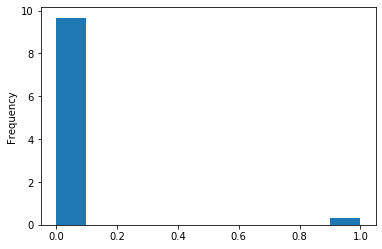

In [8]:
pd.Series(y).plot.hist(density=True)

In [9]:
sss = StratifiedShuffleSplit(n_splits=5)
X=np.array(X)
y=np.array(y)
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),('model',RandomForestClassifier(random_state=42, n_estimators=400, max_depth=3, class_weight='balanced'))])
pipeline = Pipeline([('tfidf',TfidfVectorizer()),('model',XGBClassifier(max_depth=5))])
#pipeline = Pipeline([('tfidf',TfidfVectorizer(tokenizer=goldberg_old_tokenizer)),('model',lgb.LGBMClassifier(max_depth=3))])
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)), ('svd',TruncatedSVD(n_components=300)),('model',CatBoostClassifier(random_state=42, verbose=0))])
print('cohens kappa score: '+str(np.array(cross_val_score(pipeline, X, y, scoring=make_scorer(cohen_kappa_score), cv=sss)).mean()))

cohens kappa score: 0.6644513368380526


In [10]:
#feature_importance=[100*x for x in pipeline.named_steps['model'].feature_importances_.tolist()]
pipeline.fit(X,y)
feature_importance=[x for x in pipeline.named_steps['model'].feature_importances_.tolist()]

In [11]:
feature_names=pipeline.named_steps['tfidf'].get_feature_names()

In [12]:
features_ratings=pd.DataFrame({"Names":feature_names,"Importance":feature_importance})

In [13]:
features_ratings=features_ratings.sort_values(by='Importance', ascending=False)

In [14]:
features_ratings

,Names,Importance
2482,בתאונת,0.055049
12367,רכב,0.054429
2480,בתאונה,0.052956
10008,מפגיעת,0.046305
10238,משאית,0.044162
12205,קשה,0.039734
5129,התאונה,0.039532
13414,תאונה,0.039154
13416,תאונת,0.038498
2339,ברכב,0.036485


In [49]:
# yap_tokenized_sentences=[]
# for i, sentence in enumerate(sentences):
#     yap_tokenized_sentences.append(yap_tokenizer(sentence))
yap_tokenized_sentences=pd.read_pickle('yap_tokenized_sentences.pkl').tolist()

In [484]:
X = []

for sentence in yap_tokenized_sentences:
    X.append(str(' '.join(sentence)))

# for sentence in tqdm(sentences):
#     X.append(' '.join([word.text for word in nlp(str(sentence)).sentences[0].words if type(word)!=float and word.text!=None]))

In [473]:
sss = StratifiedShuffleSplit(n_splits=10)
X=np.array(X)
y=np.array(y)
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),('model',RandomForestClassifier(random_state=42, n_estimators=400, max_depth=3, class_weight='balanced'))])
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),('model',XGBClassifier(random_state=42))])
pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),('model',lgb.LGBMClassifier(reg_lambda=1,max_depth=3,is_unbalance=True,random_state=42))])
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)), ('svd',TruncatedSVD(n_components=300)),('model',CatBoostClassifier(random_state=42, verbose=0))])
print('cohens kappa score: '+str(np.array(cross_val_score(pipeline, X, y, scoring=make_scorer(cohen_kappa_score), cv=skf)).mean()))

cohens kappa score: 0.728275538465518


In [485]:
#feature_importance=[100*x for x in pipeline.named_steps['model'].feature_importances_.tolist()]
pipeline.fit(X,y)
feature_importance=[x for x in pipeline.named_steps['model'].feature_importances_.tolist()]

In [486]:
feature_names=pipeline.named_steps['tfidf'].get_feature_names()

In [487]:
features_ratings=pd.DataFrame({"Names":feature_names,"Importance":feature_importance})

In [488]:
features_ratings=features_ratings.sort_values(by='Importance', ascending=False)

In [489]:
features_ratings

,Names,Importance
3248,תאונה,54
2278,נפצע,51
2601,פגיעה,43
2266,נפגע,40
3021,רכב,23
2937,קשה,22
479,בן,15
2148,נהג,14
1564,ישראלי,10
3241,שריפה,10


# FastText

In [15]:
X=[]
for sentence in sentences:
    X.append(model.get_sentence_vector(' '.join(goldberg_old_tokenizer(sentence))))

In [16]:
from keras import Sequential
from keras.layers import Dense,BatchNormalization

Using TensorFlow backend.


In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback

class SkMetrics(Callback):
    def on_train_begin(self, logs={}):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []
        self.kappa = []        

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict(self.validation_data[0]))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]
        
        self.confusion.append(confusion_matrix(targ, predict))
        self.precision.append(precision_score(targ, predict))
        self.recall.append(recall_score(targ, predict))
        self.f1s.append(f1_score(targ, predict))
        self.kappa.append(cohen_kappa_score(targ, predict))

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [19]:
from tensorflow.contrib.metrics import cohen_kappa

In [20]:
import tensorflow as tf

In [21]:
def auc_roc(y_true, y_pred):  
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred, num_thresholds=200, curve='ROC', summation_method='careful_interpolation' )
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]
    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)
    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [22]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [23]:
from keras import backend as K


def precision(y_true, y_pred):	
    """Precision metric.	
    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision

def recall(y_true, y_pred):	
    """Recall metric.	
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

def f1_score(y_true, y_pred):
    """Computes the F1 Score
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (2 * p * r) / (p + r + K.epsilon())

In [24]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print('— val_f1: %f — val_precision: %f — val_recall %f'%(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()

In [25]:
from keras.wrappers.scikit_learn import KerasClassifier

In [26]:
net=Sequential()
net.add(Dense(128, activation='relu', input_shape=(300,)))
net.add(BatchNormalization())
net.add(Dense(64, activation='relu'))
net.add(BatchNormalization())
net.add(Dense(32, activation='relu'))
net.add(BatchNormalization())
net.add(Dense(1, activation='sigmoid'))
net.compile(optimizer='adam', loss='binary_crossentropy')

W0720 11:36:22.212417  9420 deprecation_wrapper.py:119] From C:\Users\saske\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 11:36:22.218418  9420 deprecation_wrapper.py:119] From C:\Users\saske\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 11:36:22.226419  9420 deprecation_wrapper.py:119] From C:\Users\saske\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 11:36:22.287268  9420 deprecation_wrapper.py:119] From C:\Users\saske\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 11:36:22.414296  9420 deprecation_wrappe

In [27]:
X_train, X_test, y_train, y_test=train_test_split(np.array(X),y)

In [28]:
history=net.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=2)

Train on 5130 samples, validate on 1711 samples
Epoch 1/10
 - 5s - loss: 0.4975 - val_loss: 0.2850
Epoch 2/10
 - 2s - loss: 0.1711 - val_loss: 0.1111
Epoch 3/10
 - 2s - loss: 0.0668 - val_loss: 0.0641
Epoch 4/10
 - 2s - loss: 0.0426 - val_loss: 0.0565
Epoch 5/10
 - 2s - loss: 0.0310 - val_loss: 0.0545
Epoch 6/10
 - 2s - loss: 0.0280 - val_loss: 0.0530
Epoch 7/10
 - 2s - loss: 0.0191 - val_loss: 0.0482
Epoch 8/10
 - 2s - loss: 0.0131 - val_loss: 0.0523
Epoch 9/10
 - 2s - loss: 0.0138 - val_loss: 0.0493
Epoch 10/10
 - 2s - loss: 0.0137 - val_loss: 0.0531


In [29]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'loss'])


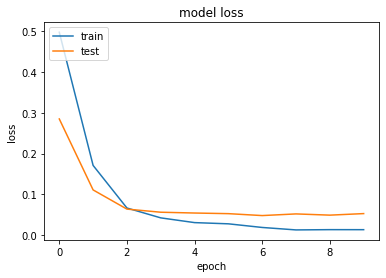

In [30]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history[net.metrics_names[1]])
# plt.plot(history.history['val_'+net.metrics_names[1]])
# plt.title('model '+net.metrics_names[1])
# plt.ylabel(net.metrics_names[1])
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history[net.metrics_names[0]])
plt.plot(history.history['val_'+net.metrics_names[0]])
plt.title('model '+net.metrics_names[0])
plt.ylabel(net.metrics_names[0])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
def make_keras_model():
    net=Sequential()
    net.add(Dense(128, activation='relu', input_shape=(300,)))
    net.add(BatchNormalization())
    net.add(Dense(64, activation='relu'))
    net.add(BatchNormalization())
    net.add(Dense(32, activation='relu'))
    net.add(BatchNormalization())
    net.add(Dense(1, activation='sigmoid'))
    net.compile(optimizer='adam', loss='binary_crossentropy')
    return net

In [62]:
sss = StratifiedShuffleSplit(n_splits=10)
X=np.array(X)
y=np.array(y)
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),('model',RandomForestClassifier(random_state=42, n_estimators=400, max_depth=3, class_weight='balanced'))])
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),('model',XGBClassifier(random_state=42))])
pipeline = Pipeline([('model',KerasClassifier(make_keras_model, epochs=3, verbose=2))])
#pipeline = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)), ('svd',TruncatedSVD(n_components=300)),('model',CatBoostClassifier(random_state=42, verbose=0))])
print('cohens kappa score: '+str(np.array(cross_val_score(pipeline, X, y, scoring=make_scorer(cohen_kappa_score), cv=sss)).mean()))

Epoch 1/3
 - 4s - loss: 0.4586
Epoch 2/3
 - 2s - loss: 0.1221
Epoch 3/3
 - 2s - loss: 0.0572
Epoch 1/3
 - 4s - loss: 0.4468
Epoch 2/3
 - 2s - loss: 0.1194
Epoch 3/3
 - 2s - loss: 0.0566
Epoch 1/3
 - 4s - loss: 0.4469
Epoch 2/3
 - 2s - loss: 0.1216
Epoch 3/3
 - 2s - loss: 0.0542
Epoch 1/3
 - 4s - loss: 0.4417
Epoch 2/3
 - 2s - loss: 0.1275
Epoch 3/3
 - 2s - loss: 0.0615
Epoch 1/3
 - 5s - loss: 0.4452
Epoch 2/3
 - 2s - loss: 0.1247
Epoch 3/3
 - 2s - loss: 0.0580
Epoch 1/3
 - 5s - loss: 0.4497
Epoch 2/3
 - 2s - loss: 0.1207
Epoch 3/3
 - 2s - loss: 0.0581
Epoch 1/3
 - 5s - loss: 0.4396
Epoch 2/3
 - 2s - loss: 0.1243
Epoch 3/3
 - 2s - loss: 0.0612
Epoch 1/3
 - 5s - loss: 0.4557
Epoch 2/3
 - 2s - loss: 0.1252
Epoch 3/3
 - 2s - loss: 0.0586
Epoch 1/3
 - 5s - loss: 0.4273
Epoch 2/3
 - 2s - loss: 0.1159
Epoch 3/3
 - 2s - loss: 0.0554
Epoch 1/3
 - 5s - loss: 0.4507
Epoch 2/3
 - 2s - loss: 0.1233
Epoch 3/3
 - 2s - loss: 0.0569
cohens kappa score: 0.6746685869313607


In [9]:
fasttext_dataset=dataset[['accident','title']]

In [10]:
sss = StratifiedShuffleSplit(n_splits=10)

In [11]:
def inplace_change(filename, old_string, new_string):
    with open(filename,encoding="utf8") as f:
        newText=f.read().replace(old_string, new_string)
    with open(filename, "w", encoding="utf8") as f:
        f.write(newText)

In [47]:
from typing import Any, Iterable, List, Optional, Set, Tuple
import math

Vector = List[float]

def most_similar(base_vector: Vector, words: List[Word]) -> List[Tuple[float, Word]]:
    """Finds n words with smallest cosine similarity to a given word"""
    words_with_distance = [(cosine_similarity_normalized(base_vector, w.vector), w) for w in words]
    # We want cosine similarity to be as large as possible (close to 1)
    sorted_by_distance = sorted(words_with_distance, key=lambda t: t[0], reverse=True)
    return sorted_by_distance

def print_most_similar(words: List[Word], text: str) -> None:
    base_word = find_word(text, words)
    if not base_word:
        print(f"Uknown word: {text}")
        return
    print(f"Words related to {base_word.text}:")
    sorted_by_distance = [
        word.text for (dist, word) in
            most_similar(base_word.vector, words)
            if word.text.lower() != base_word.text.lower()
        ]
    print(', '.join(sorted_by_distance[:10]))

def read_word() -> str:
    return input("Type a word: ")

def find_word(text: str, words: List[Word]) -> Optional[Word]:
#     try:
#         return next(w for w in words if text == w.text)
#     except StopIteration:
#         return None
    return words[text]

def closest_analogies(
    left2: str, left1: str, right2: str, words: List[Word]
) -> List[Tuple[float, Word]]:
    word_left1 = find_word(left1, words)
    word_left2 = find_word(left2, words)
    word_right2 = find_word(right2, words)
#     if (not word_left1) or (not word_left2) or (not word_right2):
#         return []
    vector = add(
        sub(word_left1, word_left2),
        word_right2)
    closest = most_similar(vector, words)[:10]
    def is_redundant(word: str) -> bool:
        """
        Sometimes the two left vectors are so close the answer is e.g.
        "shirt-clothing is like phone-phones". Skip 'phones' and get the next
        suggestion, which might be more interesting.
        """
        word_lower = word.lower()
        return (
            left1.lower() in word_lower or
            left2.lower() in word_lower or
            right2.lower() in word_lower)
    closest_filtered = [(dist, w) for (dist, w) in closest if not is_redundant(w.text)]
    return closest_filtered

def print_analogy(left2: str, left1: str, right2: str, words: List[Word]) -> None:
    analogies = closest_analogies(left2, left1, right2, words)
    if (len(analogies) == 0):
        print(f"{left2}-{left1} is like {right2}-?")
    else:
        (dist, w) = analogies[0]
        #alternatives = ', '.join([f"{w.text} ({dist})" for (dist, w) in analogies])
        print(f"{left2}-{left1} is like {right2}-{w.text}")

def l2_len(v: Vector) -> float:
    return math.sqrt(sum([x*x for x in v]))

def dot(v1: Vector, v2: Vector) -> float:
    assert len(v1) == len(v2)
    return sum([x*y for (x,y) in zip(v1, v2)])

def add(v1: Vector, v2: Vector) -> Vector:
    assert len(v1) == len(v2)
    return [x + y for (x,y) in zip(v1, v2)]

def sub(v1: Vector, v2: Vector) -> Vector:
    assert len(v1) == len(v2)
    return [x - y for (x,y) in zip(v1, v2)]

def normalize(v: Vector) -> Vector:
    l = l2_len(v)
    return [x / l for x in v]

def cosine_similarity_normalized(v1: Vector, v2: Vector) -> float:
    """
    Returns the cosine of the angle between the two vectors.
    Each of the vectors must have length (L2-norm) equal to 1.
    Results range from -1 (very different) to 1 (very similar).
    """
    return dot(v1, v2)


class Word:
    """A single word (one line of the input file)"""

    def __init__(self, text: str, vector: Vector, frequency: int) -> None:
        self.text = text
        self.vector = vector
        self.frequency = frequency

    def __repr__(self) -> str:
        vector_preview = ', '.join(map(str, self.vector[:2]))
        return f"{self.text} [{vector_preview}, ...]"
    
from typing import Iterable, List, Set

from itertools import groupby
from operator import itemgetter
import re

def load_words(file_path: str) -> List[Word]:
    """Load and cleanup the data."""
    print(f"Loading {file_path}...")
    words = load_words_raw(file_path)
    print(f"Loaded {len(words)} words.")

    #num_dimensions = most_common_dimension(words)
    words = [w for w in words if len(w.vector) == 300]
    #print(f"Using {num_dimensions}-dimensional vectors, {len(words)} remain.")

    words = remove_stop_words(words)
    print(f"Removed stop words, {len(words)} remain.")

    words = remove_duplicates(words)
    print(f"Removed duplicates, {len(words)} remain.")

    return words

def load_words_raw(file_path: str) -> List[Word]:
    """Load the file as-is, without doing any validation or cleanup."""
    def parse_line(line: str, frequency: int) -> Word:
        tokens = line.split()
        word = tokens[0]
        vector = normalize([float(x) for x in tokens[1:]])
        return Word(word, vector, frequency)

    words = []
    # Words are sorted from the most common to the least common ones
    frequency = 1
    with open(file_path, encoding='utf8') as f:
        for line in f:
            w = parse_line(line, frequency)
            words.append(w)
            frequency += 1
    return words

def iter_len(iter: Iterable[complex]) -> int:
    return sum(1 for _ in iter)

def most_common_dimension(words: List[Word]) -> int:
    """
    There is a line in the input file which is missing a word
    (search -0.0739, -0.135, 0.0584).
    """
    lengths = sorted([len(word.vector) for word in words])
    dimensions = [(k, iter_len(v)) for k, v in groupby(lengths)]
    print("Dimensions:")
    for (dim, num_vectors) in dimensions:
        print(f"{num_vectors} {dim}-dimensional vectors")
    most_common = sorted(dimensions, key=lambda t: t[1], reverse=True)[0]
    return most_common[0]

# We want to ignore these characters,
# so that e.g. "U.S.", "U.S", "US_" and "US" are the same word.
ignore_char_regex = re.compile("[\W_]")

# Has to start and end with an alphanumeric character
is_valid_word = re.compile("^[^\W_].*[^\W_]$")

def remove_duplicates(words: List[Word]) -> List[Word]:
    seen_words: Set[str] = set()
    unique_words: List[Word] = []
    for w in words:
        canonical = ignore_char_regex.sub("", w.text)
        if not canonical in seen_words:
            seen_words.add(canonical)
            # Keep the original ordering
            unique_words.append(w)
    return unique_words

def remove_stop_words(words: List[Word]) -> List[Word]:
    return [w for w in words if (
        len(w.text) > 1 and is_valid_word.match(w.text))]

In [45]:
words = load_words('cc.he.300.vec')

Loading cc.he.300.vec...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\saske\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-ccdf4e349410>", line 1, in <module>
    words = load_words('cc.he.300.vec')
  File "<ipython-input-44-b81786369115>", line 119, in load_words
    words = load_words_raw(file_path)
  File "<ipython-input-44-b81786369115>", line 146, in load_words_raw
    for line in f:
  File "C:\Users\saske\Anaconda3\lib\codecs.py", line 319, in decode
    def decode(self, input, final=False):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\saske\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent

TypeError: can only concatenate str (not "list") to str

In [48]:
print_analogy('מלך', 'מלכה' , 'נסיך', model)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [25]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))


for train_ind, test_ind in sss.split(fasttext_dataset['title'],fasttext_dataset['accident']):
    fasttext_dataset_train=fasttext_dataset.loc[train_ind,:]
    fasttext_dataset_train.loc[:,'title']=' __label__'+fasttext_dataset_train.loc[:,'accident'].astype(str)+' '+fasttext_dataset_train.loc[:,'title']
    fasttext_dataset_train['title'].to_csv('news_flash_19_7_19_data_train.txt',index=False, header=False)
    fasttext_dataset_test=fasttext_dataset.loc[test_ind,:]
    fasttext_dataset_test.loc[:,'title']='__label__'+fasttext_dataset_test.loc[:,'accident'].astype(str)+' '+fasttext_dataset_test.loc[:,'title']
    fasttext_dataset_test['title'].to_csv('news_flash_19_7_19_data_test.txt',index=False, header=False)
    inplace_change('news_flash_19_7_19_data_train.txt','\"','')
    inplace_change('news_flash_19_7_19_data_train.txt','\'','')
    inplace_change('news_flash_19_7_19_data_test.txt','\"','')
    inplace_change('news_flash_19_7_19_data_test.txt','\'','')
    fasttext_supervised=fasttext.train_supervised('news_flash_19_7_19_data_train.txt', )
    print_results(*fasttext_supervised.test('news_flash_19_7_19_data_test.txt', k=2))

N	685
P@1	0.500
R@1	1.000
N	685
P@1	0.500
R@1	1.000


KeyboardInterrupt: 

In [23]:
fasttext_supervised.predict('תאונת דרכים עם נפצעים',k=2)

(('__label__False', '__label__True'), array([9.99458015e-01, 5.62023022e-04]))

In [116]:
fasttext_supervised.labels

['__label__False', '__label__True']

In [32]:
fasttext_dataset.loc[:,'title']=fasttext_dataset.loc[:,'title']+' __label__'+fasttext_dataset.loc[:,'accident'].astype(str)

C:\Users\saske\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
fasttext_supervised=fasttext.train_supervised('news_flash_19_7_19_data.txt')

In [52]:
from gensim.models import fasttext as ft

model = ft.load_facebook_model('cc.he.300.bin')

print(model.most_similar('מורה'))
# Output = [('headteacher', 0.8075869083404541), ('schoolteacher', 0.7955552339553833), ('teachers', 0.733420729637146), ('teaches', 0.6839243173599243), ('meacher', 0.6825737357139587), ('teach', 0.6285147070884705), ('taught', 0.6244685649871826), ('teaching', 0.6199781894683838), ('schoolmaster', 0.6037642955780029), ('lessons', 0.5812176465988159)]

print(model.similarity('מורה', 'ללמד'))

C:\Users\saske\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


[('ומורה', 0.7511934041976929), ('1.מורה', 0.6926032304763794), ('.מורה', 0.6877073049545288), ('2.מורה', 0.6840677261352539), ('המורה', 0.681587815284729), ('מורה-מחנך', 0.6695026755332947), ('כמורה', 0.6671140789985657), ('kמורה', 0.6603051424026489), ('למורה', 0.6582226753234863), ('ךמורה', 0.6465803384780884)]


C:\Users\saske\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


0.43108505


In [66]:
model.wv.most_similar(positive=['מלך', 'מלכה'], negative=['אישה'])

[('מלכהּ', 0.5259336233139038),
 ('ומלך', 0.49719732999801636),
 ('ומלכה', 0.48895424604415894),
 ('מלכהבן', 0.4842609763145447),
 ('מלכי', 0.47994059324264526),
 ('ומלכי', 0.4713260531425476),
 ('ממליך', 0.4627130627632141),
 ('למלך', 0.4592019319534302),
 ('מלכהלע', 0.454645037651062),
 ('המלך', 0.44962286949157715)]